In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from fastai.models.unet import *
import json

/home/nbuser/.anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
TRAIN_DN = 'final_train'
MASKS_DN = 'final_mask'
PATH = Path('/home/nbuser/fastai/old')
sz = 128
bs = 64
nw = 16

In [5]:
tr_path = Path('project/final_train')
msk_path = Path('project/final_mask')
train_dir = os.listdir('project/final_train')
msk_dir = os.listdir('project/final_mask')
#open_image(TRAIN_DN/train_dir[0])
ims = [open_image(tr_path/train_dir[i]) for i in range(16)]
im_masks = [open_image(msk_path/msk_dir[i]) for i in range(16)]
#print(train_dir[:5])
#print(msk_dir[-5:])

In [6]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [7]:
x_names = np.array([tr_path/o for o in train_dir])

In [8]:
y_names = np.array([msk_path/f'{o[:-4]}.png' for o in train_dir])

In [9]:
val_idxs = list(range(300))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)
print(trn_x[:5])

[PosixPath('project/final_train/000000028998.jpg') PosixPath('project/final_train/000000023311.jpg')
 PosixPath('project/final_train/000000569901.jpg') PosixPath('project/final_train/000000050204.jpg')
 PosixPath('project/final_train/000000545919.jpg')]


In [10]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [11]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [12]:
x,y = next(iter(md.trn_dl))

In [13]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

In [14]:
f = resnet34
cut,lr_cut = model_meta[f]

In [15]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [16]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [17]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [18]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [19]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]
# class UpsampleModel():
#     def __init__(self, model, cut_lr, name='upsample'):
#         self.model,self.name, self.cut_lr = model, name, cut_lr

#     def get_layer_groups(self, precompute):
#         lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
#         return lgs + [children(self.model)[1:]]

In [20]:
m_base = get_base()

In [21]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)
# m = DynamicUnet(m_base, n_classes=1) 
# inp = torch.ones(1,3,sz,sz)
# out = m(V(inp).cpu())
# m = m.cuda(0)
# cut,cut_lr = model_meta[resnet18]
# models = UpsampleModel(m,cut_lr)

In [22]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [23]:
learn.freeze_to(1)

 95%|█████████▌| 19/20 [00:10<00:00,  2.33it/s, loss=1.71]

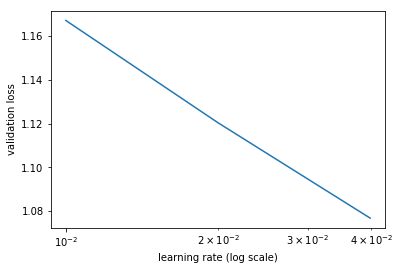

In [25]:
learn.lr_find()
learn.sched.plot()

In [26]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [27]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.726354   2161.530892 0.730971   0.0       
    1      0.632816   0.766028   0.730548   0.001576       
    2      0.542218   0.580593   0.730507   0.016366       
    3      0.462054   0.419916   0.79118    0.530263       


[0.4199161084493001, 0.7911800177892049, 0.5302630678812663]

In [28]:
learn.save('total_new_128')

In [29]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [30]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax
#show_img(py[4]>0);

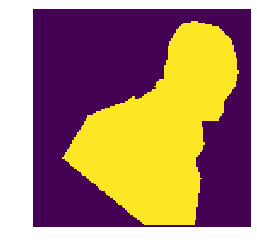

In [31]:
yy = y.cpu().numpy()
show_img(yy[3]);

In [32]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [33]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [34]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [35]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [36]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [34]:
#torch.save(models,'test.pt')

In [37]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [38]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 

In [39]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [40]:
learn.freeze_to(1)

 95%|█████████▌| 19/20 [00:09<00:00,  2.44it/s, loss=1.57] 

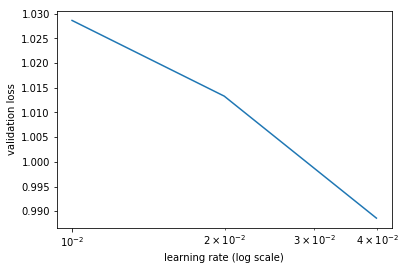

In [41]:
learn.lr_find()
learn.sched.plot()

In [42]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [43]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.42146    47.155386  0.328344   0.440269  
    1      0.307412   0.282487   0.901459   0.818252       
    2      0.257244   0.214743   0.90144    0.82092        
    3      0.224782   0.259653   0.883921   0.779398       
    4      0.202286   0.208456   0.906795   0.831115       
    5      0.185744   0.192722   0.918567   0.851526       
    6      0.171873   0.177622   0.923835   0.861999       
    7      0.159403   0.194048   0.917439   0.84889        


[0.19404782652854918, 0.91743896484375, 0.8488902139663697]

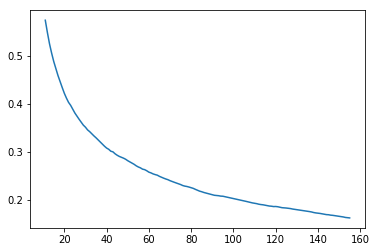

In [44]:
learn.sched.plot_loss()
#learn.sched.plot_loss
loss_1 = learn.sched.losses

In [45]:
learn.save('total_new_128urn-tmp')

In [46]:
learn.load('total_new_128urn-tmp')

In [47]:
learn.unfreeze()
learn.bn_freeze(True)

In [48]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.125775   0.183313   0.921983   0.85941   
    1      0.125689   0.178495   0.927293   0.866801       
    2      0.123852   0.18003    0.929409   0.86819        
    3      0.121421   0.21324    0.912881   0.840414       
    4      0.119469   0.181302   0.926482   0.86598        
    5      0.11729    0.169838   0.931179   0.874561       
    6      0.114121   0.181514   0.932213   0.874917       
    7      0.110377   0.181854   0.928925   0.870282       
    8      0.107378   0.190351   0.929708   0.869712       
    9      0.104612   0.181484   0.932546   0.875965       
    10     0.10189    0.180146   0.934123   0.877668       
    11     0.099768   0.17873    0.934358   0.878965        
    12     0.097993   0.189889   0.93233    0.874274        
    13     0.095924   0.178789   0.936189   0.882085        
    14     0.09479    0.174583   0.934897   0.880492        
    15     0.093305   0.183308   0.935083

[0.18263814667860667, 0.9346175154050191, 0.8795785943667094]

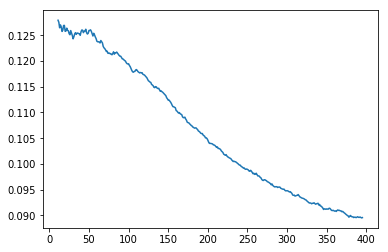

In [49]:
learn.sched.plot_loss()
#learn.sched.plot_loss
loss_2 = learn.sched.losses
learn.save('total_best_128urn-0')

In [50]:
learn.load('total_best_128urn-0')

In [51]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

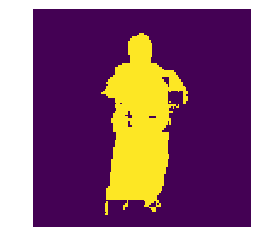

In [66]:
show_img(py[8]>0);

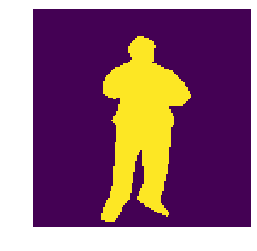

In [67]:
show_img(yy[8]);

In [68]:
m.close()

In [69]:
sz=512
bs=16

In [70]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [71]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)


In [72]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [73]:
learn.freeze_to(1)

In [74]:
learn.load('total_best_128urn-0')

In [75]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.231891   0.446774   0.85557    0.745013  
    1      0.203392   0.21216    0.921633   0.854178       
    2      0.174959   0.181295   0.92753    0.863925       
    3      0.160433   0.185096   0.931365   0.870429       
    4      0.136142   0.154331   0.934501   0.879653       


[0.15433100382486978, 0.9345007467269898, 0.8796533703804016]

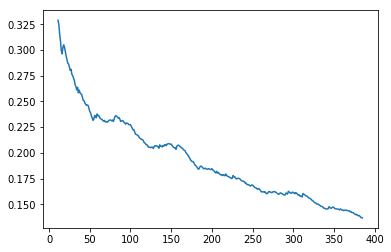

In [76]:
learn.sched.plot_loss()
#learn.sched.plot_loss
loss_3 = learn.sched.losses

In [77]:
learn.save('total_new_512urn-tmp')

In [78]:
learn.unfreeze()
learn.bn_freeze(True)

In [80]:
learn.load('total_new_512urn-tmp')

In [81]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.114884   0.15569    0.936634   0.882953  
    1      0.122543   0.170177   0.936998   0.878821       
    2      0.126057   0.147986   0.940001   0.890535       
    3      0.107629   0.144422   0.942798   0.894815       
    4      0.10069    0.141529   0.943052   0.895558       
    5      0.094389   0.142695   0.94274    0.895115        
    6      0.091425   0.141518   0.943536   0.896473        
    7      0.08883    0.140581   0.944209   0.897694        


[0.14058138052622476, 0.9442093785603841, 0.8976940560340881]

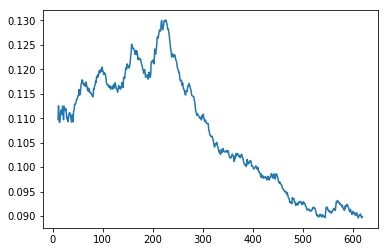

In [82]:
learn.sched.plot_loss()
#learn.sched.plot_loss
loss_4 = learn.sched.losses

In [83]:
learn.save('total_best_512urn')

In [84]:
learn.load('total_best_512urn')


In [85]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

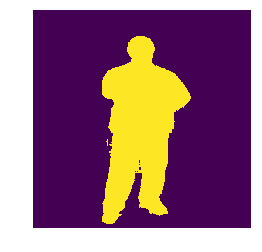

In [104]:
show_img(py[8]>0);

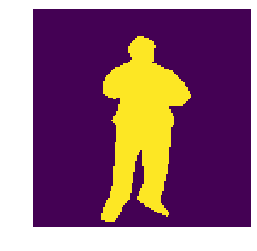

In [105]:
show_img(yy[8]);

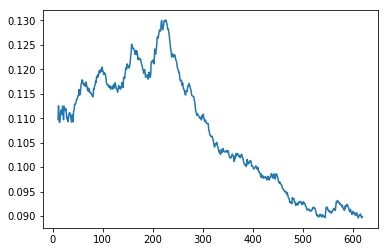

In [106]:
learn.sched.plot_loss()

In [107]:
learn.load('total_best_512urn')

In [108]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.099604   0.142734   0.938946   0.890299  
    1      0.105067   0.147024   0.938925   0.888574        
    2      0.099322   0.15307    0.937919   0.887423        
    3      0.092038   0.169067   0.940824   0.888167        
    4      0.088067   0.148968   0.942527   0.892744        
    5      0.085447   0.149176   0.943417   0.895336        
    6      0.081284   0.154304   0.942771   0.893211        
    7      0.080021   0.147777   0.943977   0.8964          


[0.14777737180391948, 0.9439767336845398, 0.8964001528422038]

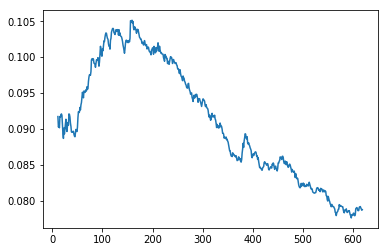

In [109]:
learn.sched.plot_loss()
#learn.sched.plot_loss
loss_5 = learn.sched.losses
learn.save('total_best_512')
#torch.save(models,'test.h5')

In [113]:
#print(len(loss_0))
print(len(loss_1))
print(len(loss_2))
print(len(loss_3))
print(len(loss_4))
print(len(loss_5))

160
400
390
624
624


In [114]:
#print(type(loss_1))
arr_1 = np.array(loss_1)
arr_1 = np.resize(arr_1,(120,1))

arr_2 = np.array(loss_2)
arr_2 = np.resize(arr_2,(120,1))

arr_3 = np.array(loss_3)
arr_3 = np.resize(arr_3,(120,1))

arr_4 = np.array(loss_4)
arr_4 = np.resize(arr_4,(120,1))

arr_5 = np.array(loss_5)
arr_5 = np.resize(arr_5,(120,1))
np.save('arr_1.npy',arr_1)
np.save('arr_2.npy',arr_2)
np.save('arr_3.npy',arr_3)
np.save('arr_4.npy',arr_4)
#np.save('arr_1.npy',arr_1)

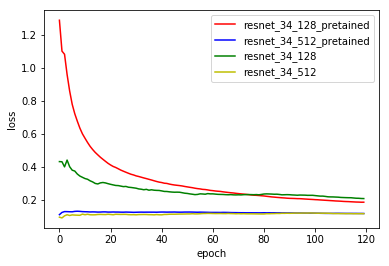

In [112]:
import matplotlib.pyplot as plt
plt.plot(arr_1,c='r',label = 'resnet_34_128_pretained')
plt.plot(arr_2,c='b',label = 'resnet_34_512_pretained')
plt.plot(arr_3,c='g',label = 'resnet_34_128')
plt.plot(arr_4,c='y',label = 'resnet_34_512')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.plot(arr_5,c='black')
plt.legend()
plt.savefig('loss.png')
plt.show()

